<a href="https://colab.research.google.com/github/Ad-Rian815/Unza_journal_key_word_classification/blob/main/Automatic_Classification_Of_Key_Words_Associated_with_articles_on_Unza_journals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding


## 1.1 Problem Statement
Currently, keywords associated with research articles in UNZA journals are not automatically organized or classified. This makes it difficult for researchers, students, and librarians to quickly identify relevant articles or track research trends. A manual process is time-consuming, inconsistent, and limits the usefulness of the institutional repository. Navigation of journals will be a piece of cake!

## 1.2 Business Objectives
The goal of this project is to build a system that can automatically classify keywords from articles into meaningful categories (e.g., *Agriculture, Medicine, Computer Science*).  

From a real-world perspective, success means:
- Improving searchability and retrieval of research articles.
- Helping researchers discover related works faster.
- Supporting administrators in analyzing research output trends at UNZA.

##1.3 Data Mining Goal
  
  The technical approach to achieving these objectives is structured into the following data mining goals:

   1.Classification Model Development: A classification model will be built to  categorize article keywords into predefined classes.

  2.Text Preprocessing: The raw text data will be prepared for machine learning using standard preprocessing techniques, including tokenization, stop-word removal, and TF-IDF (Term          Frequency-Inverse Document Frequency) for vectorization.

  3.Algorithm Experimentation: The performance of several classification algorithms will be evaluated to determine the most effective one. The algorithms to be tested include Naïve          Bayes,   Support Vector Machines (SVM), and Decision Trees.
  
  To wrap things up, the main goal of this project is to build a machine learning model that can automatically classify article keywords. We've broken the work down into two key           parts. First, we'll focus on data preparation by cleaning the text using tokenization and stop-word removal, and then we'll use TF-IDF to turn everything into numbers for the models     to work with.
  
  For the second part, we'll experiment with different algorithms like Naïve Bayes, SVM, and Decision Trees. By testing them with metrics like precision and F1-score, then we'll           figure out which one is the most accurate. We're hoping that by following these steps, we can successfully create a model that not only classifies keywords effectively but also          shows we've got a solid grasp of the data mining process.

   Summary: The workflow involves two main stages.
  First, text preprocessing to clean and transform raw keywords into numerical representations.
  Second, experimentation with multiple algorithms to identify the most accurate and robust classifier.

    1.3.1 Data Preparation
       Before building the model the data will be,
       Tokenized into smaller units.
       Cleaned by removing stop words and irrelevant terms.
       Converted into numerical representations using TF-IDF for input into machine learning models.

## 1.4 Project Success Criteria
- The model should achieve at least **80% accuracy** on the test dataset.
- The classification results must be **interpretable and consistent** across different domains.
- The classification outputs are clear and be easily explained to non-technical stakeholders.
- The system should reduce the time required to organize keywords compared to manual methods.

# Data Understanding


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE_URL = "https://journals.unza.zm"

def get_journal_links():
    response = requests.get(BASE_URL)
    soup = BeautifulSoup(response.text, "html.parser")
    links = []
    for a in soup.select("a"):
        href = a.get("href")
        if href and "index.php" in href:
            links.append(BASE_URL + href if not href.startswith("http") else href)
    return list(set(links))

def scrape_articles(journal_url, max_pages=3):
    articles = []
    for page in range(1, max_pages+1):
        url = f"{journal_url}?page={page}"
        response = requests.get(url)
        if response.status_code != 200:
            break

        soup = BeautifulSoup(response.text, "html.parser")
        for article in soup.select("div.title a"):
            article_url = article.get("href")
            article_url = article_url if article_url.startswith("http") else BASE_URL + article_url
            article_data = scrape_article_metadata(article_url)
            if article_data:
                articles.append(article_data)
            # polite delay
            time.sleep(1)
    return articles

def _extract_author_names(soup):
    # 1) Prefer OJS meta tags (names only)
    meta_authors = [m.get("content", "").strip()
                    for m in soup.select('meta[name="citation_author"]')
                    if m.get("content")]
    if meta_authors:
        # de-dup while preserving order
        seen = set()
        ordered = []
        for a in meta_authors:
            if a and a not in seen:
                seen.add(a)
                ordered.append(a)
        return ", ".join(ordered)

    # 2) Fall back to elements that specifically hold names
    name_selectors = [
        ".authors .name",
        ".author .name",
        "li.authors .name",
        "div#authors .name",
        ".article-authors .name",
    ]
    for sel in name_selectors:
        els = [e.get_text(strip=True) for e in soup.select(sel)]
        els = [e for e in els if e]
        if els:
            # remove obvious ORCID ids or emails if any slipped in
            cleaned = []
            for txt in els:
                # strip ORCID URLs/ids and emails in case they appear alongside names

                txt = txt.replace("ORCID", "")
                # very light cleanup without changing the site logic
                cleaned.append(txt.strip(" ,;"))
            # de-dup
            seen = set()
            ordered = []
            for a in cleaned:
                if a and a not in seen:
                    seen.add(a)
                    ordered.append(a)
            return ", ".join(ordered)

    generic = [e.get_text(strip=True) for e in soup.select(".authors span, .authors div")]
    if generic:
        names = []
        for t in generic:
            # keep short tokens that look like names (very light heuristic)
            if len(t.split()) <= 6 and "http" not in t.lower() and "@" not in t and ":" not in t:
                names.append(t.strip(" ,;"))
        # if that yields something believable, join; else return joined generic
        if names:
            # de-dup
            seen = set()
            ordered = []
            for a in names:
                if a and a not in seen:
                    seen.add(a)
                    ordered.append(a)
            return ", ".join(ordered)
        return ", ".join(generic)
    return None

def scrape_article_metadata(article_url):
    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch {article_url}: Status {response.status_code}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        # Debug
        print(f"\n--- Debugging {article_url} ---")

        # Title
        title = None
        title_selectors = ["h1.page_title", "h1", ".page_title", ".article-title", "h1.title"]
        for selector in title_selectors:
            element = soup.select_one(selector)
            if element:
                title = element.get_text().strip()
                print(f"Title found with selector '{selector}': {title[:50]}...")
                break

        # Authors: (names only)
        authors = _extract_author_names(soup)
        if authors:
            print(f"Authors (names only): {authors}")
        else:
            print("Authors not found with name-specific selectors; see page for structure.")

        # Abstract
        abstract = None
        abstract_selectors = ["div.abstract", ".abstract", ".article-abstract", "div.description"]
        for selector in abstract_selectors:
            element = soup.select_one(selector)
            if element:
                abstract = element.get_text().strip()
                break

        # Keywords
        keywords = None
        keyword_selectors = ["div.keywords", ".keywords", ".article-keywords", ".tags"]
        for selector in keyword_selectors:
            element = soup.select_one(selector)
            if element:
                keywords = element.get_text().strip()
                break

        return {
            "title": title,
            "authors": authors,
            "abstract": abstract,
            "keywords": keywords,
            "url": article_url
        }

    except Exception as e:
        print(f"Error scraping {article_url}: {str(e)}")
        return None

if __name__ == "__main__":
    journal_links = get_journal_links()
    print(f"Found {len(journal_links)} journals")

    all_articles = []
    for journal in journal_links[:2]:
        print(f"\nScraping {journal} ...")
        articles = scrape_articles(journal, max_pages=1)
        all_articles.extend(articles)
        if len(all_articles) >= 5:
            break

    df = pd.DataFrame(all_articles)
    df.to_csv("/content/drive/My Drive/folders/unza_journals.csv", index=False)


    print(f"\n--- SUMMARY ---")
    print(f"Total articles scraped: {len(all_articles)}")
    print(f"Articles with authors: {len([a for a in all_articles if a['authors']])}")
    print(f"Articles with titles: {len([a for a in all_articles if a['title']])}")

    for i, article in enumerate(all_articles[:3]):
        print(f"\nArticle {i+1}:")
        for key, value in article.items():
            if value:
                print(f"  {key}: {str(value)[:100]}{'...' if len(str(value)) > 100 else ''}")

    print("Debug scraping completed. Data saved to unza_journals.csv")


Mounted at /content/drive
Found 34 journals

Scraping https://journals.unza.zm/index.php/medicine/issue/current ...

--- Debugging https://journals.unza.zm/index.php/medicine/article/view/1096 ---
Title found with selector 'h1.page_title': Editorial-Forecasting the anthrax outbreak dynamic...
Authors (names only): Brian Chanda Chiluba

--- Debugging https://journals.unza.zm/index.php/medicine/article/view/1098 ---
Title found with selector 'h1.page_title': Mismanagement of pesticides among smallholder farm...
Authors (names only): Kweleka Mwanza, Jasper Musa, Bridget Bwalya

--- Debugging https://journals.unza.zm/index.php/medicine/article/view/1099 ---
Title found with selector 'h1.page_title': Impact of the COVID-19 pandemic on people living w...
Authors (names only): Ethel N Malambo

--- Debugging https://journals.unza.zm/index.php/medicine/article/view/1100 ---
Title found with selector 'h1.page_title': HIV and cardiovascular disease: A review of awaren...
Authors (names only): Mwe

OSError: Cannot save file into a non-existent directory: '/content/drive/My Drive/folders'

Shape of dataset: (5, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     5 non-null      object
 1   authors   5 non-null      object
 2   abstract  5 non-null      object
 3   keywords  5 non-null      object
 4   url       5 non-null      object
dtypes: object(5)
memory usage: 332.0+ bytes
None

First 5 rows:
                                               title  \
0  Performance of Cowpea Progenitor and Hybrids i...   
1  Exploring Dietary Patterns and Nutrition Statu...   
2  Potential of a Powdered Mopane Worms-Breakfast...   
3  Programmed Death Ligand-1 Expression in Gastri...   
4  Contagious Bovine Pleuropneumonia-Associated F...   

                                             authors  \
0                                 Emmanuel Chikalipa   
1  Nixon Miyoba, Abidan Chansa, Namakando Liusha,...   
2  Yongo Salasini, Nixon Miyoba,

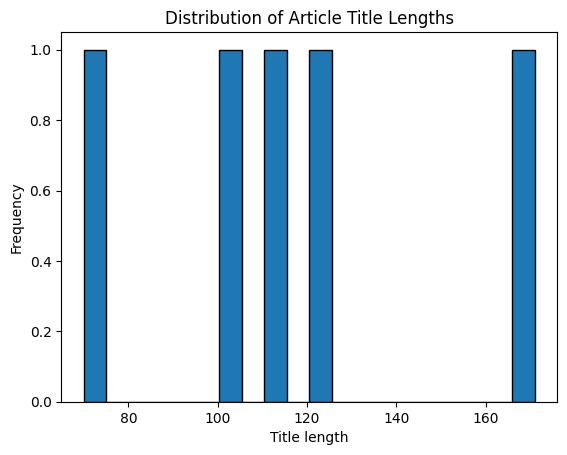

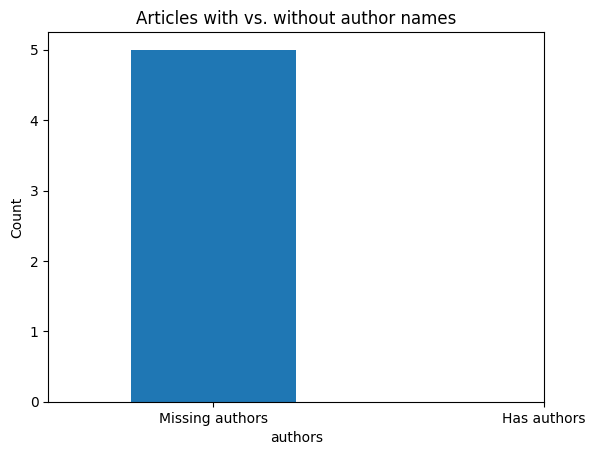

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


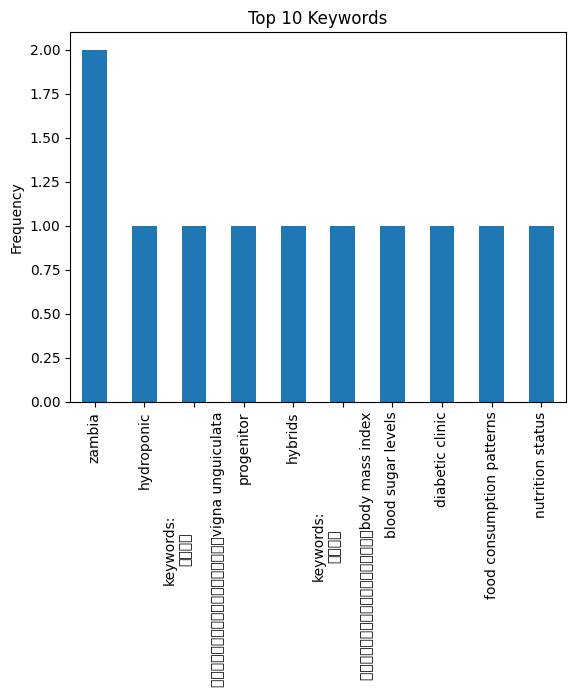


--- Summary of Initial Findings ---
Dataset has 5 rows and 6 columns.
Articles with missing titles: 0
Articles with missing authors: 0
Articles with missing abstracts: 0
Articles with missing keywords: 0


In [7]:
# 1. Load your dataset
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("unza_journals_debug.csv")

# 2. Initial exploration
print("Shape of dataset:", df.shape)
print("\nInfo:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nSummary statistics (numeric only):")
print(df.describe(include="all"))

# 3. Initial visualizations
# Histogram of title lengths (proxy for numerical distribution)
df['title_length'] = df['title'].astype(str).apply(len)
plt.hist(df['title_length'], bins=20, edgecolor='black')
plt.xlabel("Title length")
plt.ylabel("Frequency")
plt.title("Distribution of Article Title Lengths")
plt.show()

# Bar chart of number of articles with vs. without authors
author_counts = df['authors'].notna().value_counts()
author_counts.plot(kind="bar")
plt.xticks([0, 1], ["Missing authors", "Has authors"], rotation=0)
plt.ylabel("Count")
plt.title("Articles with vs. without author names")
plt.show()

# Top keywords frequency (if present)
if "keywords" in df.columns:
    keyword_series = df['keywords'].dropna().str.lower().str.split(",")
    flat_keywords = [k.strip() for sublist in keyword_series for k in sublist]
    pd.Series(flat_keywords).value_counts().head(10).plot(kind="bar")
    plt.ylabel("Frequency")
    plt.title("Top 10 Keywords")
    plt.show()

# 4. Brief summary
print("\n--- Summary of Initial Findings ---")
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Articles with missing titles: {df['title'].isna().sum()}")
print(f"Articles with missing authors: {df['authors'].isna().sum()}")
print(f"Articles with missing abstracts: {df['abstract'].isna().sum()}")
print(f"Articles with missing keywords: {df['keywords'].isna().sum()}")
